# Homework Code, then below that is class notes!

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from ipywidgets import interact, FloatSlider # you may need to install ipywidgets via pip or conda

In [33]:
pip install pydot graphviz

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 47 kB 6.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Math 390: MCMC and Metropolis-Hastings - Friday October 3, 2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from ipywidgets import interact, FloatSlider # you may need to install ipywidgets via pip or conda

## 4.1

[np.float64(2.0),
 np.float64(3.14432),
 np.float64(4.18344),
 np.float64(4.91872),
 np.float64(5.24736),
 np.float64(5.1808),
 np.float64(4.82432),
 np.float64(4.00384),
 np.float64(3.456),
 np.float64(2.68288)]

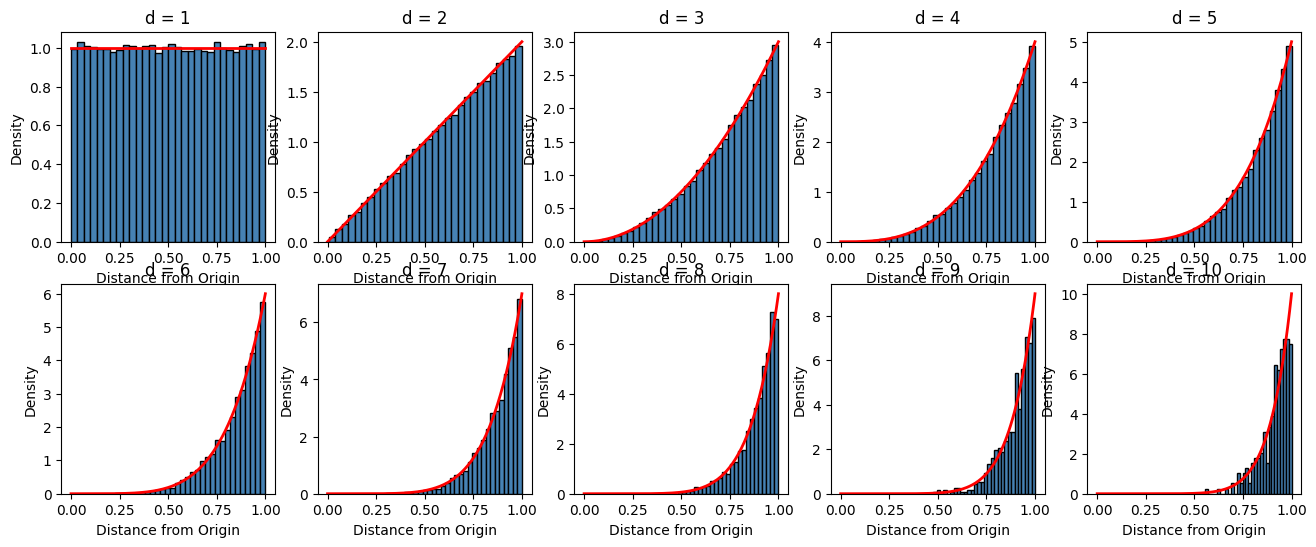

In [23]:
N = 100000
dims = [1,2,3,4,5,6,7,8,9,10]
## Two-dimension example
x = 2*np.random.rand(N) -1
y = 2*np.random.rand(N) -1
indicator = x**2 + y**2 <= 1
(sum(indicator)/N)*4

## Extending to d-dimensions
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()

volumes = []
for  d in dims:
    X = 2 * np.random.rand(N, d) - 1
    
    radius_sq = np.sum(X**2, axis=1)
    radius = np.sqrt(radius_sq)
    inside = radius_sq <= 1
    r_inside = radius[inside]
    volume_estimate = (np.sum(inside) / N) * (2 ** d)
    volumes.append(volume_estimate)

    ax = axes[d-1]
    ax.hist(r_inside, bins=30, density=True, color='steelblue', edgecolor='black')
    r_vals = np.linspace(0, 1, 200)
    f_r = d * r_vals**(d - 1)
    ax.plot(r_vals, f_r, 'r-', lw=2, label=r"$f(r)=d\,r^{d-1}$")
    ax.set_title(f"d = {d}")
    ax.set_xlabel("Distance from Origin")
    ax.set_ylabel("Density")

volumes

## 5.1

/var/folders/11/kvq0xg6s0bx1p71gxd2f0ss80000gn/T/ipykernel_37718/2818270664.py:14: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.graphviz_layout(nx_graph, prog="neato")


[1, 4, 2, 3, 2, 4, 1, 2, 3, 4, 2, 1, 4, 5, 5, 4, 2, 4, 2, 1, 2, 3, 4, 3, 2, 3]


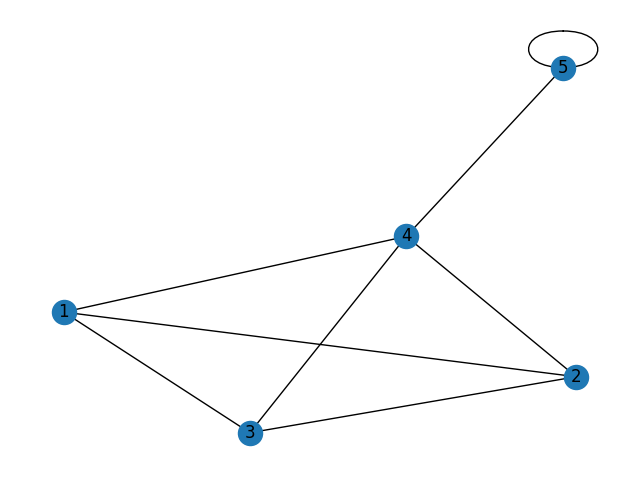

In [39]:
graph_neighbors = {
    1: [2, 3,4],
    2: [1, 3, 4],
    3: [1, 2, 4],
    4: [1,2,3,5],
    5: [4,5]
}
import networkx as nx
from IPython.display import HTML   
#from networkx.drawing.nx_agraph import graphviz_layout 

nx_graph = nx.Graph(graph_neighbors)
# pos = nx.spring_layout(nx_graph)
pos = nx.nx_pydot.graphviz_layout(nx_graph, prog="neato")
fig, ax = plt.subplots(figsize=(8, 6))
nx.draw(nx_graph, pos=pos, ax=ax)
nx.draw_networkx_labels(nx_graph, pos, ax=ax)

import random as rnd 


def random_walk(graph, start_vertex=None, steps=10):
    if start_vertex is None:
        start_vertex = rnd.choice(list(graph.keys()))
    
    current_vertex = start_vertex
    walk_sequence = [current_vertex]
    
    for _ in range(steps):
        neighbors = graph[current_vertex]
        if not neighbors:  # If the vertex has no neighbors, stop the walk
            break
        current_vertex = rnd.choice(neighbors)
        walk_sequence.append(current_vertex)
    
    return walk_sequence


def graph_neighbor_from_networkx(nx_graph):
    return {vertex: list(nx_graph.neighbors(vertex)) for vertex in nx_graph}

walk_path = random_walk(graph_neighbors, start_vertex=1, steps=25)
print(walk_path)

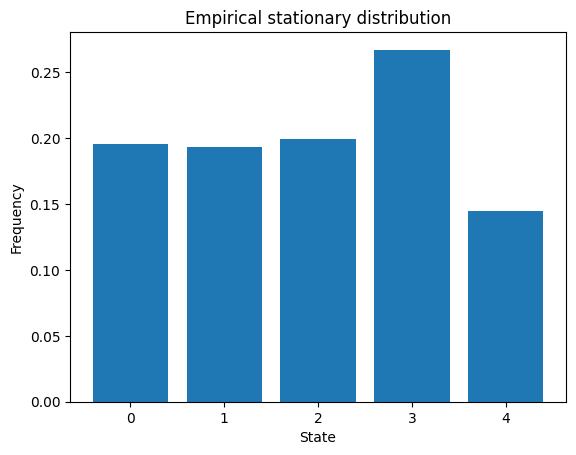

In [44]:
def stationary_distribution(P):
    # Solve for eigenvector of P^T with eigenvalue 1
    w, v = np.linalg.eig(P.T)
    # Extract eigenvector corresponding to eigenvalue 1
    idx = np.argmin(np.abs(w - 1))
    stat = np.real(v[:, idx])
    # Normalize so it sums to 1
    pi = stat / stat.sum()
    return pi

P = np.array([[0,1/3,1/3,1/3,0],
             [1/3,0,1/3,1/3,0],
             [1/3,1/3,0,1/3,0],
             [1/4,1/4,1/4,0,1/4],
             [0,0,0,1/2,1/2]])

stationary_distribution(P)

def simulate_chain(P, start=0, steps=10000):
    n_states = P.shape[0]
    state = start
    history = [state]
    for _ in range(steps-1):
        state = np.random.choice(range(n_states), p=P[state])
        history.append(state)
    return np.array(history)

chain = simulate_chain(P)

plt.hist(chain, bins=np.arange(P.shape[0]+1)-0.5, density=True, rwidth=0.8)
plt.xlabel("State")
plt.ylabel("Frequency")
plt.title("Empirical stationary distribution")
plt.show()


## 6.2

In [53]:
def metropolized_random_walk(graph, start_vertex=None, steps=10):
    if start_vertex is None:
        start_vertex = rnd.choice(list(graph.keys()))
    
    current_vertex = start_vertex
    walk_sequence = [current_vertex]
    
    for _ in range(steps):
        neighbors = graph[current_vertex]
        if not neighbors:  # If the vertex has no neighbors, stop the walk
            break
        proposed_vertex = rnd.choice(neighbors)
        num_neighbor_neighbors = len(graph[proposed_vertex])
        acceptance_ratio = len(neighbors)/num_neighbor_neighbors
        if rnd.random() < acceptance_ratio:
            current_vertex = proposed_vertex
        walk_sequence.append(current_vertex)
    
    return walk_sequence

walk_path = metropolized_random_walk(graph_neighbors, start_vertex=1, steps=20000)

visit_counts = np.zeros(len(graph_neighbors)+1)
for w in walk_path:
    visit_counts[w] += 1

total_visits = sum(visit_counts)
for i in [1,2,3,4,5]:
    print("Prob of visiting",i,":",visit_counts[i]/total_visits)

Prob of visiting 1 : 0.20493975301234937
Prob of visiting 2 : 0.19854007299635018
Prob of visiting 3 : 0.2031398430078496
Prob of visiting 4 : 0.19794010299485026
Prob of visiting 5 : 0.19544022798860056


### Monte Carlo allows us to sample from a distribution and estimate integrals. Here we will estimate the integral of exp(x) from 0 to 1 using Monte Carlo sampling.

(1) In the cell below, we define the function to integrate and compute the true value of the integral for comparison. What do you observe you you run the cell with different values of N (number of samples)? 

(2) Change $f(x)$ to be $\sin(x)$ and compute the integral from 0 to $\pi$. What is the true value of this integral? Run the cell with different values of N. What do you observe?

(3) Change $f(x)$ to be $x^2$ and compute the integral from 0 to 1. What is the true value of this integral? Run the cell with different values of N. What do you observe?

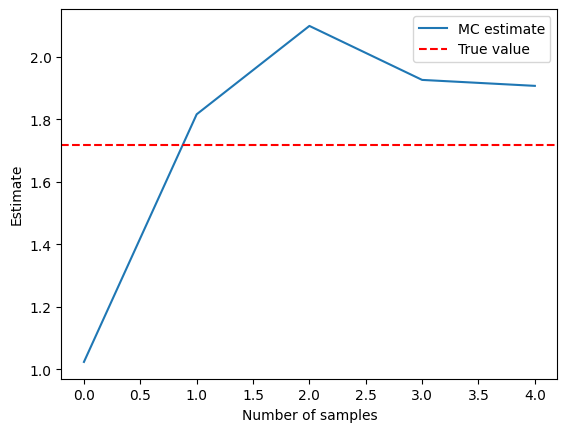

In [2]:
# function to integrate
def f(x):
    return np.exp(x)

# true value
true_val = np.e - 1  # integral of exp(x) from 0 to 1

# Monte Carlo estimates
N = 5
samples = np.random.rand(N)
estimates = np.cumsum(f(samples)) / np.arange(1, N+1)

plt.plot(estimates, label="MC estimate")
plt.axhline(true_val, color="red", linestyle="--", label="True value")
plt.xlabel("Number of samples")
plt.ylabel("Estimate")
plt.legend()
plt.show()

### We can use Markov chains to approximate expectations with respect to complicated distributions. We can do this by generating a long trajectory and then averaging the values of the function along the trajectory. This is similar to Monte Carlo integration, but the samples are not independent.

The following code shows a simple random walk on a graph that converges to a stationary distribution. This shows that even if we don't sample independently, we can still approximate expectations once our Markov chain mixes. 

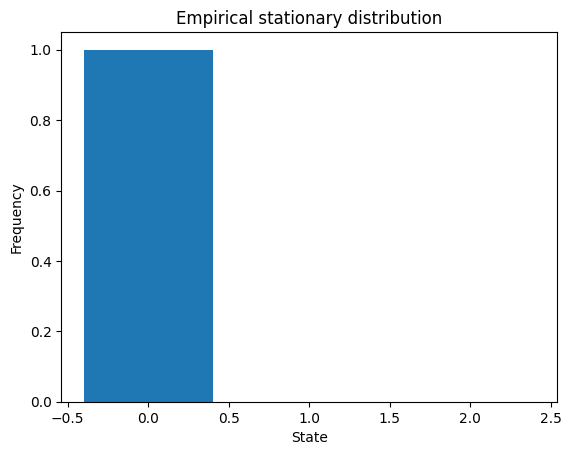

In [3]:
# Transition matrix for simple random walk on 3 states
P = np.array([[0.5, 0.5, 0.0],
              [0.25, 0.5, 0.25],
              [0.0, 0.5, 0.5]])

def simulate_chain(P, start=0, steps=10000):
    n_states = P.shape[0]
    state = start
    history = [state]
    for _ in range(steps-1):
        state = np.random.choice(range(n_states), p=P[state])
        history.append(state)
    return np.array(history)

chain = simulate_chain(P, steps=1)
plt.hist(chain, bins=np.arange(P.shape[0]+1)-0.5, density=True, rwidth=0.8)
plt.xlabel("State")
plt.ylabel("Frequency")
plt.title("Empirical stationary distribution")
plt.show()

In [4]:
### Symmetric random walk

P1 = np.array([[0.5, 0.5, 0.0],
               [0.25, 0.5, 0.25],
               [0.0, 0.5, 0.5]])

### Biased chain

P2 = np.array([[0.1, 0.9, 0.0],
               [0.2, 0.6, 0.2],
               [0.0, 0.8, 0.2]])

### Slow mixing 

P3 = np.array([[0.95, 0.05, 0.0],
               [0.1, 0.8, 0.1],
               [0.0, 0.05, 0.95]])

### Uniform chain

P4 = np.array([[1/3, 1/3, 1/3],
               [1/3, 1/3, 1/3],
               [1/3, 1/3, 1/3]])

### Cycle

P5 = np.array([[0.0, 1.0, 0.0],
               [0.0, 0.0, 1.0],
               [1.0, 0.0, 0.0]])

For each $P$ above, simulate a long trajectory (e.g. 20000 steps). Observe how the empirical distribution of the states visited converges to the stationary distribution as the trajectory length increases by varying the number of steps.

Estimate the empirical stationary distribution for each $P$ by averaging the states visited in the trajectory and plot the histogram of the states visited in the trajectory. How does this compare across the different $P$?

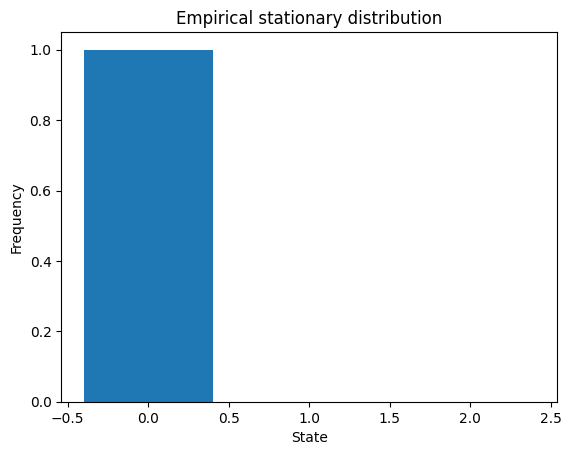

In [5]:
chain = simulate_chain(P, steps=1)

plt.hist(chain, bins=np.arange(P.shape[0]+1)-0.5, density=True, rwidth=0.8)
plt.xlabel("State")
plt.ylabel("Frequency")
plt.title("Empirical stationary distribution")
plt.show()

### Recall that the stationary distribution $\pi$ is the left eigenvector of the transition matrix $P$ with eigenvalue 1, i.e. $\pi P = \pi$. 

The following function computes the stationary distribution of a given transition matrix $P$. Use the function below to compute true the stationary distribution for each $P$ and compare it to your empirical estimates.

In [6]:
def stationary_distribution(P):
    # Solve for eigenvector of P^T with eigenvalue 1
    w, v = np.linalg.eig(P.T)
    # Extract eigenvector corresponding to eigenvalue 1
    idx = np.argmin(np.abs(w - 1))
    stat = np.real(v[:, idx])
    # Normalize so it sums to 1
    pi = stat / stat.sum()
    return pi

Consider global and detailed balance for the transition matrices above. Use the functions below to check if global and detailed balance hold for each $P$ with respect to its stationary distribution.

In [7]:
def check_global_balance(P, pi):
    lhs = pi
    rhs = pi @ P   # matrix multiplication: row vector pi times P
    print("LHS (pi):", lhs)
    print("RHS (pi P):", rhs)
    return np.allclose(lhs, rhs)

def check_detailed_balance(P, pi, tol=1e-8):
    n = len(pi)
    for i in range(n):
        for j in range(n):
            lhs = pi[i]*P[i,j]
            rhs = pi[j]*P[j,i]
            if not np.isclose(lhs, rhs, atol=tol):
                print(f"Fails at ({i},{j}): {lhs:.4f} vs {rhs:.4f}")
                return False
    return True

### Visualizing Detailed Balance as Flux Equilibrium

In this example, we will explore how **detailed balance** can be interpreted as a **flux equilibrium** in a Markov chain. Each edge in the graph represents a possible transition between states, and the **weight of the edge corresponds to the flux**:

$$
F_{ij} = \pi_i P_{ij}
$$

where $\pi_i$ is the stationary probability of state $i$, and $P_{ij}$ is the transition probability from state $i$ to $j$.  

**Key concepts to observe:**

1. **Detailed balance:** For a reversible chain, the flux on each edge is symmetric:
   $$
   F_{ij} = F_{ji} \quad \text{or equivalently} \quad \pi_i P_{ij} = \pi_j P_{ji}
   $$  
   If this holds, there is **no net flow** along any edge.

2. **Global balance:** Even if detailed balance does not hold, total inflow = total outflow at each node:
   $$
   \sum_i \pi_i P_{ij} = \pi_j
   $$  

3. **Self-loops:** Staying in the same state also contributes to inflow and outflow.  

**Instructions for the interactive widget:**

- Use the sliders to adjust transition probabilities between states.  
- Observe how the **fluxes on the edges** change.  
- Try to create a situation where:
  - Detailed balance holds (edges balanced pairwise).  
  - Detailed balance fails but global balance still holds (net circular flux).  
- Notice the role of self-loops in maintaining the stationary distribution.

The goal of this visualization is to help you **see detailed balance as equilibrium of flux**.

In [10]:
# Analytical stationary distribution for 3-state chain
def stationary_3state(p01, p12, p10, p21):
    # Using symbolic solution for small chain
    # pi = [pi0, pi1, pi2] normalized
    pi0 = p10 * p21 / (p01*p21 + p10*p21 + p01*p12)
    pi1 = p01 * p21 / (p01*p21 + p10*p21 + p01*p12)
    pi2 = p01 * p12 / (p01*p21 + p10*p21 + p01*p12)
    return np.array([pi0, pi1, pi2])

def plot_flux_fast(p01=0.5, p12=0.5, p10=0.25, p21=0.25):
    # Transition matrix
    P = np.array([
        [1-p01, p01, 0.0],
        [p10, 1-(p10+p12), p12],
        [0.0, p21, 1-p21]
    ])
    
    # Stationary distribution (analytical, very fast)
    pi = stationary_3state(p01, p12, p10, p21)
    
    # Compute fluxes F_ij = pi_i * P_ij
    edges = []
    for i in range(3):
        for j in range(3):
            if P[i,j] > 0:
                edges.append((i, j, pi[i]*P[i,j]))
    
    # Build graph
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges)
    
    pos = {0:(0,0), 1:(1,1), 2:(2,0)}
    
    plt.figure(figsize=(6,4))
    nx.draw(G, pos, with_labels=True, node_size=2000, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos,
                                 edge_labels={(u,v):f"{d['weight']:.2f}" for u,v,d in G.edges(data=True)})
    plt.title("Flux visualization: π_i * P_ij ")
    plt.show()

# Interactive sliders
interact(plot_flux_fast,
         p01=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5, description='P0→1'),
         p12=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5, description='P1→2'),
         p10=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.25, description='P1→0'),
         p21=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.25, description='P2→1')
)

interactive(children=(FloatSlider(value=0.5, description='P0→1', max=1.0, step=0.05), FloatSlider(value=0.5, d…

<function __main__.plot_flux_fast(p01=0.5, p12=0.5, p10=0.25, p21=0.25)>

### Exploring Metropolis–Hastings MCMC

In this activity, we will explore how **Metropolis–Hastings (MH)** allows us to sample from a distribution that is difficult to sample directly. Our target distribution is:

$$
\pi(x) \propto e^{-x^4}, \quad x \in \mathbb{R}
$$

This distribution is not standard and cannot be sampled directly using common random number generators.

---

#### Instructions

1. **Run the Metropolis–Hastings sampler** provided in the code cell.  
   - You can set the **initial state `x0`**, the **number of steps `n_steps`**, and the **proposal standard deviation `sigma`**.  

2. **Observe the resulting samples**:
   - Compare the histogram of samples with the true target distribution (plotted in red).  
   - Notice how the samples “fill out” the shape of the distribution over time.  

3. **Experiment with parameters**:
   - **Sigma (`σ`)**: Controls the size of proposed moves.
     - Small `σ`: the chain moves slowly, high autocorrelation, slow mixing.  
     - Large `σ`: many proposals are rejected, chain can get “stuck”.  
   - **Initial state `x0`**: Try starting at different points (e.g., 0 or 2). The chain should eventually converge to the same target distribution.  
   - **Number of steps `n_steps`**: Observe convergence to stationary distribution as the chain runs longer.  

4. **Compute expectations**:
   - Use your samples to estimate quantities like $(\mathbb{E}[X^2]$ or $\mathbb{E}[X^4]%. Compare with numerical integration if you like.  

5. **Discussion points**:
   - How does the **accept/reject step** ensure detailed balance?  
   - Why does the chain eventually converge to the target distribution even if we start far away?  
   - How do proposal size and acceptance rate influence convergence speed?  
   - How is this different from **naive Monte Carlo** where we sample independently?

---

Use this interactive exploration to build intuition for **how MCMC constructs a Markov chain** that has the **desired stationary distribution**, even when direct sampling is impossible. Experiment with parameters and compare the results to the target distribution.

In [11]:
# Target distribution (unnormalized)
def pi(x):
    return np.exp(-x**4)

# Metropolis-Hastings sampler
def metropolis_hastings(x0, n_steps=10000, sigma=1.0):
    samples = np.zeros(n_steps)
    x = x0
    for i in range(n_steps):
        x_proposal = x + np.random.normal(0, sigma)
        alpha = min(1, pi(x_proposal)/pi(x))
        if np.random.rand() < alpha:
            x = x_proposal
        samples[i] = x
    return samples

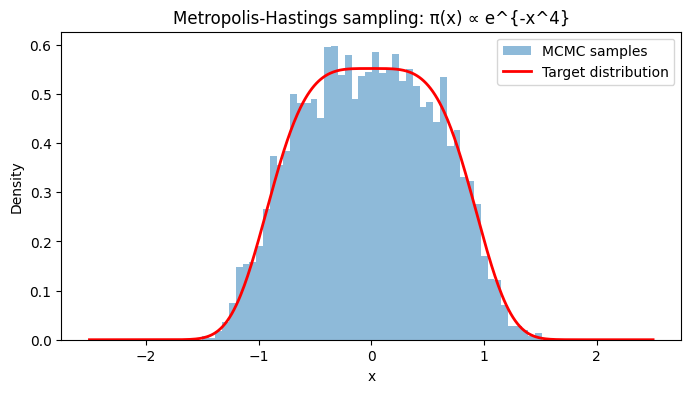

In [12]:
# Example run
samples = metropolis_hastings(x0=0.0, n_steps=10000, sigma=0.8)

# Plot results
x_vals = np.linspace(-2.5, 2.5, 500)
plt.figure(figsize=(8,4))
plt.hist(samples, bins=50, density=True, alpha=0.5, label="MCMC samples")
plt.plot(x_vals, pi(x_vals)/np.trapz(pi(x_vals), x_vals), 'r', lw=2, label="Target distribution")
plt.title("Metropolis-Hastings sampling: π(x) ∝ e^{-x^4}")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

In [13]:
expected_X2 = np.mean(samples**2)
print(f"Estimated E[X^2] from MCMC: {expected_X2:.4f}")

Estimated E[X^2] from MCMC: 0.3428
